Synthesized velocity field shape: torch.Size([3, 512, 512, 512])


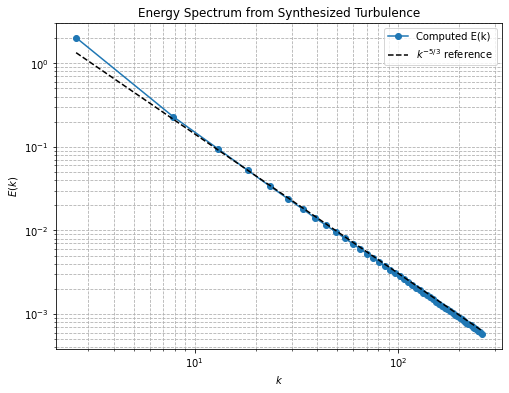

In [1]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters and Device Setup ---
device = torch.device("cpu")  # change to "cuda" if you have a GPU
N = 512                     # Number of grid points per dimension
L = 2 * np.pi               # Domain length, so domain is [0, 2*pi]^3
dx = L / N                  # Grid spacing

# --- Step 1: Create the Fourier grid ---
# Construct 1D Fourier frequencies for x and y directions
k1d = torch.cat((torch.arange(0, N//2, device=device), torch.arange(-N//2, 0, device=device)))
# For the third direction (z) use only non-negative frequencies (for rfft)
kz = torch.arange(0, N//2 + 1, device=device)

# Create 3D grids with "ij" indexing
KX, KY, KZ = torch.meshgrid(k1d, k1d, kz, indexing='ij')
# Compute the magnitude of the wavevector (avoid division by zero later)
kmag = torch.sqrt(KX.to(torch.float32)**2 + KY.to(torch.float32)**2 + KZ.to(torch.float32)**2)
nonzero = kmag > 0  # mask to avoid k=0

# --- Step 2: Generate random Fourier coefficients with Kolmogorov scaling ---
# We generate a velocity vector field in Fourier space with shape (3, N, N, N//2+1)
shape = (3, N, N, N//2+1)
# Generate random complex numbers with independent real and imaginary parts
uhat = (torch.randn(shape, dtype=torch.complex64, device=device) +
        1j * torch.randn(shape, dtype=torch.complex64, device=device))
uhat = uhat / np.sqrt(2)  # normalization

# Kolmogorov scaling:
# In 3D, if E(k) ∝ k^(-5/3) then one common choice is to set |û(k)| ∝ k^(-11/6)
A0 = 1.0  # Overall amplitude (adjust if needed)
# Create amplitude array: note that we only scale for nonzero k
amplitude = torch.zeros_like(kmag, dtype=torch.float32)
amplitude[nonzero] = A0 * (kmag[nonzero])**(-11/6)
# Expand amplitude dimensions so it applies to each velocity component
amplitude = amplitude.unsqueeze(0)  # shape now (1, N, N, N//2+1)
uhat = uhat * amplitude

# --- Step 3: Enforce the divergence–free condition (incompressibility) ---
# Construct the 3–component wavevector K = (KX, KY, KZ)
KX = KX.to(torch.float32)
KY = KY.to(torch.float32)
KZ = KZ.to(torch.float32)
K = torch.stack((KX, KY, KZ), dim=0)  # shape (3, N, N, N//2+1)
# Compute the dot product k·û for each Fourier mode over the three velocity components
dot = (K * uhat).sum(dim=0)  # shape (N, N, N//2+1)
# Compute k^2 for each mode (with proper broadcasting)
kmag2 = kmag**2
kmag2_expanded = kmag2.unsqueeze(0)  # shape (1, N, N, N//2+1)
# Projection: subtract the component along k to enforce (k · û = 0)
projection = K * (dot / kmag2_expanded)
uhat = torch.where(kmag2_expanded > 0, uhat - projection, uhat)

# --- Step 4: Inverse FFT to Recover the Real-space Velocity Field ---
# u_field will be a real-valued field with shape (3, N, N, N)
u_field = torch.zeros((3, N, N, N), dtype=torch.float32, device=device)
for i in range(3):
    u_field[i] = torch.fft.irfftn(uhat[i], s=(N, N, N))

# Optionally normalize the field (e.g., set RMS velocity to 1)
rms = torch.sqrt((u_field**2).mean())
u_field = u_field / rms

print("Synthesized velocity field shape:", u_field.shape)

# --- Step 5: Compute the Energy Spectrum E(k) ---
# The energy per mode is defined as 0.5 * (|û_x|^2 + |û_y|^2 + |û_z|^2)
energy_modes = 0.5 * torch.sum(torch.abs(uhat)**2, dim=0)  # shape (N, N, N//2+1)

# Flatten the wavevector magnitudes and energy:
kmag_flat = kmag.cpu().numpy().flatten()
energy_flat = energy_modes.cpu().numpy().flatten()

# Define bins in k (spherical shells)
num_bins = 50
k_min = kmag_flat[kmag_flat > 0].min()  # exclude zero to avoid log(0)
k_max = kmag_flat.max()/1.7
bins = np.linspace(0.0, k_max, num_bins+1)  # num_bins bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
delta_k = bins[1:] - bins[:-1]

# Bin the energy using np.histogram with weights:
bin_energy, _ = np.histogram(kmag_flat, bins=bins, weights=energy_flat)
# Normalize by the bin width to obtain an estimate of the energy density E(k)
E_k = bin_energy / delta_k

# --- Step 6: Plotting the Spectrum on a Log-Log Scale ---
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, E_k, 'o-', label='Computed E(k)')

# Optionally, plot a reference line with a slope of -5/3
# We choose an arbitrary constant to align the reference line with the computed data.
ref_const = E_k[3] * (bin_centers[3]**(5/3))
plt.loglog(bin_centers, ref_const * bin_centers**(-5/3), 'k--', label=r'$k^{-5/3}$ reference')

plt.xlabel(r'$k$')
plt.ylabel(r'$E(k)$')
plt.title('Energy Spectrum from Synthesized Turbulence')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


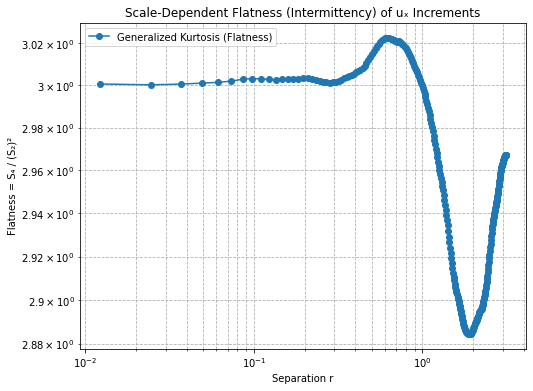

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ------------------------------
# Parameters (assumes u_field is available)
# ------------------------------
# u_field is assumed to be a torch tensor of shape (3, N, N, N) from the previous synthesis code.
# For example, u_field[0] is the x‐component.
u_field_cpu = u_field.cpu()  # move to CPU if not already
N = u_field_cpu.shape[1]
L = 2 * np.pi               # domain length [0, 2π]
dx = L / N                  # grid spacing in physical units

# ------------------------------
# Compute Structure Functions and Generalized Kurtosis
# ------------------------------
# We compute the longitudinal velocity increments along the x-direction.
# For a given separation r, we compute:
#    δu(r) = u(x + r) − u(x)
# and then average over the entire domain to get the structure functions:
#    S_p(r) = ⟨|δu(r)|^p⟩.
#
# The generalized kurtosis (for p = 4) is defined as:
#    Flatness = Γ₄(r) = S₄(r) / [S₂(r)]².

# Extract the x–component as a NumPy array.
u_x = u_field_cpu[0].numpy()  # shape (N, N, N)

max_shift = N // 2           # use up to half the domain to avoid finite-size artifacts
num_lags = max_shift         # lags index from 1 to max_shift
lags = np.arange(1, num_lags + 1) * dx  # physical separation distances

S2 = np.zeros(num_lags)
S4 = np.zeros(num_lags)

# Loop over various lag distances (shifts) along the x-axis.
for n in range(1, num_lags + 1):
    # Compute increments with a periodic (circular) shift in the x-direction.
    # np.roll handles the periodicity.
    delta_u = u_x - np.roll(u_x, shift=-n, axis=0)
    # Compute the 2nd-order structure function: S₂(n*dx)
    S2[n - 1] = np.mean(delta_u**2)
    # Compute the 4th-order structure function: S₄(n*dx)
    S4[n - 1] = np.mean(delta_u**4)

# Compute generalized kurtosis (flatness).
flatness = S4 / (S2**2)

# ------------------------------
# Plotting the Generalized Kurtosis (Intermittency)
# ------------------------------
plt.figure(figsize=(8, 6))
plt.loglog(lags, flatness, 'o-', label='Generalized Kurtosis (Flatness)')
plt.xlabel('Separation r')
plt.ylabel('Flatness = S₄ / (S₂)²')
plt.title('Scale-Dependent Flatness (Intermittency) of uₓ Increments')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
